In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set seed for reproducibility
np.random.seed(42)

def generate_ecommerce_data(rows=5000):
    # Create a pool of 1,000 unique Customer IDs
    customer_ids = [f"CUST-{i:04d}" for i in range(1, 1001)]
    
    data = {
        'CustomerID': np.random.choice(customer_ids, rows),
        'OrderDate': [datetime(2025, 1, 1) + timedelta(days=np.random.randint(0, 400)) for _ in range(rows)],
        'OrderValue': np.round(np.random.uniform(10.0, 500.0, rows), 2),
        # LastLoginDate is usually more recent than or equal to the order date
        'LastLoginDate': [datetime(2026, 1, 1) + timedelta(days=np.random.randint(0, 50)) for _ in range(rows)]
    }
    
    df = pd.DataFrame(data)
    return df

# Generate the dataset
df_orders = generate_ecommerce_data()
print(df_orders.head())


  CustomerID  OrderDate  OrderValue LastLoginDate
0  CUST-0103 2025-04-30      193.91    2026-01-06
1  CUST-0436 2026-01-17      317.11    2026-01-15
2  CUST-0861 2025-02-24       81.59    2026-01-15
3  CUST-0271 2025-01-27      413.27    2026-01-16
4  CUST-0107 2025-04-28      125.17    2026-01-20


In [13]:
# Export the raw, transaction-level data
df_orders.to_csv('Original_Transaction_Data.csv', index=False)

print(f"Complete dataset exported! Total rows: {len(df_orders)}")

Complete dataset exported! Total rows: 5000


In [14]:
def calculate_rfm(df):
    # 1. Define reference date as one day after the max order date
    reference_date = df['OrderDate'].max() + timedelta(days=1)
    
    # 2. Aggregate by CustomerID
    rfm = df.groupby('CustomerID').agg({
        'OrderDate': lambda x: (reference_date - x.max()).days, # Recency
        'CustomerID': 'count',                                 # Frequency
        'OrderValue': 'sum'                                    # Monetary
    })
    
    # 3. Rename columns for clarity
    rfm.rename(columns={
        'OrderDate': 'Recency',
        'CustomerID': 'Frequency',
        'OrderValue': 'Monetary'
    }, inplace=True)
    
    return rfm

# Execute the function
rfm_table = calculate_rfm(df_orders)
print("\n--- RFM Table ---")
print(rfm_table.head())


--- RFM Table ---
            Recency  Frequency  Monetary
CustomerID                              
CUST-0001        83          9   1901.98
CUST-0002        50          6   1382.09
CUST-0003       183          4   1039.85
CUST-0004       249          2    530.29
CUST-0005        18          5   1243.45


In [15]:
import pandas as pd
import numpy as np

# 1. Assign Scores (1-5) using quintiles
# pd.qcut splits the data into 5 equal parts
rfm_table['R_Score'] = pd.qcut(rfm_table['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_table['F_Score'] = pd.qcut(rfm_table['Frequency'], 5, labels=[1, 2, 3, 4, 5])
rfm_table['M_Score'] = pd.qcut(rfm_table['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Convert scores to integers for conditional logic
rfm_table[['R_Score', 'F_Score', 'M_Score']] = rfm_table[['R_Score', 'F_Score', 'M_Score']].astype(int)

# 2. Define Segment Logic
def assign_segment(row):
    # 'Top Tier': High scores across all three metrics (at least 4 out of 5)
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Top Tier'
    
    # 'Churn Risk': Low recency (1 or 2) but high monetary spend (4 or 5)
    # These were big spenders who haven't come back in a long time.
    elif row['R_Score'] <= 2 and row['M_Score'] >= 4:
        return 'Churn Risk'
    
    # Everything else
    else:
        return 'General'

# 3. Apply the logic to create the Segment column
rfm_table['Segment'] = rfm_table.apply(assign_segment, axis=1)

# Review the breakdown
print(rfm_table['Segment'].value_counts())
print(rfm_table.head())

Segment
General       745
Top Tier      134
Churn Risk    110
Name: count, dtype: int64
            Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
CustomerID                                                            
CUST-0001        83          9   1901.98        2        5        5   
CUST-0002        50          6   1382.09        3        3        3   
CUST-0003       183          4   1039.85        1        2        2   
CUST-0004       249          2    530.29        1        1        1   
CUST-0005        18          5   1243.45        5        3        3   

               Segment  
CustomerID              
CUST-0001   Churn Risk  
CUST-0002      General  
CUST-0003      General  
CUST-0004      General  
CUST-0005      General  


In [16]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# --- 1. GENERATE SYNTHETIC DATA ---
np.random.seed(42)
def generate_ecommerce_data(rows=5000):
    customer_ids = [f"CUST-{i:04d}" for i in range(1, 1001)]
    order_dates = [datetime(2025, 1, 1) + timedelta(days=np.random.randint(0, 365)) for _ in range(rows)]
    login_dates = [d + timedelta(days=np.random.randint(0, 30)) for d in order_dates]
    
    return pd.DataFrame({
        'CustomerID': np.random.choice(customer_ids, rows),
        'OrderDate': order_dates,
        'OrderValue': np.round(np.random.uniform(10.0, 500.0, rows), 2),
        'LastLoginDate': login_dates
    })

df_orders = generate_ecommerce_data()

# --- 2. RFM AGGREGATION & DATA CLEANING ---
reference_date = df_orders['OrderDate'].max() + timedelta(days=1)

rfm_table = df_orders.groupby('CustomerID').agg({
    'OrderDate': lambda x: (reference_date - x.max()).days,
    'CustomerID': 'count',
    'OrderValue': 'sum',
    'LastLoginDate': 'max'
}).rename(columns={'OrderDate': 'Recency', 'CustomerID': 'Frequency', 'OrderValue': 'Monetary'})

# Fix DaysSinceLastLogin: calculate and clip negatives
rfm_table['DaysSinceLastLogin'] = (reference_date - rfm_table['LastLoginDate']).dt.days.clip(lower=0)

# Define Target: Churned (1) if Recency > 180 days
rfm_table['Is_Churned'] = (rfm_table['Recency'] > 180).astype(int)

# --- 3. RFM SCORING & SEGMENTATION ---
rfm_table['R_Score'] = pd.qcut(rfm_table['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm_table['F_Score'] = pd.qcut(rfm_table['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm_table['M_Score'] = pd.qcut(rfm_table['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

def assign_segment(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4: return 'Top Tier'
    if row['R_Score'] <= 2 and row['M_Score'] >= 4: return 'Churn Risk'
    return 'General'

rfm_table['Segment'] = rfm_table.apply(assign_segment, axis=1)

# --- 4. TRAIN STABILIZED LOGISTIC REGRESSION ---
X = rfm_table[['Frequency', 'Monetary', 'DaysSinceLastLogin']]
y = rfm_table['Is_Churned']

# Scale features and add jitter to prevent math overflows
X_scaled = StandardScaler().fit_transform(X)
X_final = X_scaled + np.random.normal(0, 0.01, X_scaled.shape)

# Using 'saga' solver for better stability with noise
model = LogisticRegression(C=0.1, solver='saga', max_iter=10000)
model.fit(X_final, y)

# --- 5. OUTPUT RESULTS ---
print("--- Final Customer Segments ---")
print(rfm_table['Segment'].value_counts())

print("\n--- Feature Importance (Coefficients) ---")
importance = pd.DataFrame({'Feature': X.columns, 'Weight': model.coef_[0]})
print(importance.sort_values(by='Weight', ascending=False))

print("\n--- Final Model Performance Report ---")
print(classification_report(y, model.predict(X_final)))

--- Final Customer Segments ---
Segment
General       707
Top Tier      177
Churn Risk    110
Name: count, dtype: int64

--- Feature Importance (Coefficients) ---
              Feature    Weight
2  DaysSinceLastLogin  2.349794
1            Monetary  0.109701
0           Frequency -0.316034

--- Final Model Performance Report ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       915
           1       1.00      0.77      0.87        79

    accuracy                           0.98       994
   macro avg       0.99      0.89      0.93       994
weighted avg       0.98      0.98      0.98       994



In [17]:
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Production standard: address math issues then suppress warnings for the final report
warnings.filterwarnings('ignore', category=RuntimeWarning)

# 2. FEATURE SELECTION: Drop the proxy feature causing perfect separation
X = rfm_table[['Frequency', 'Monetary']] 
y = rfm_table['Is_Churned']

# 3. ROBUST SCALING
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. REGULARIZED MODEL: C=0.01 prevents weights from "exploding"
model = LogisticRegression(C=0.01, solver='lbfgs', max_iter=1000)
model.fit(X_scaled, y)

# 5. FINAL AUDIT
importance = pd.DataFrame({'Feature': X.columns, 'Weight': model.coef_[0]})
print("--- Final Stable Weights ---")
print(importance.sort_values(by='Weight', ascending=False))

--- Final Stable Weights ---
     Feature    Weight
1   Monetary -0.217045
0  Frequency -0.380784


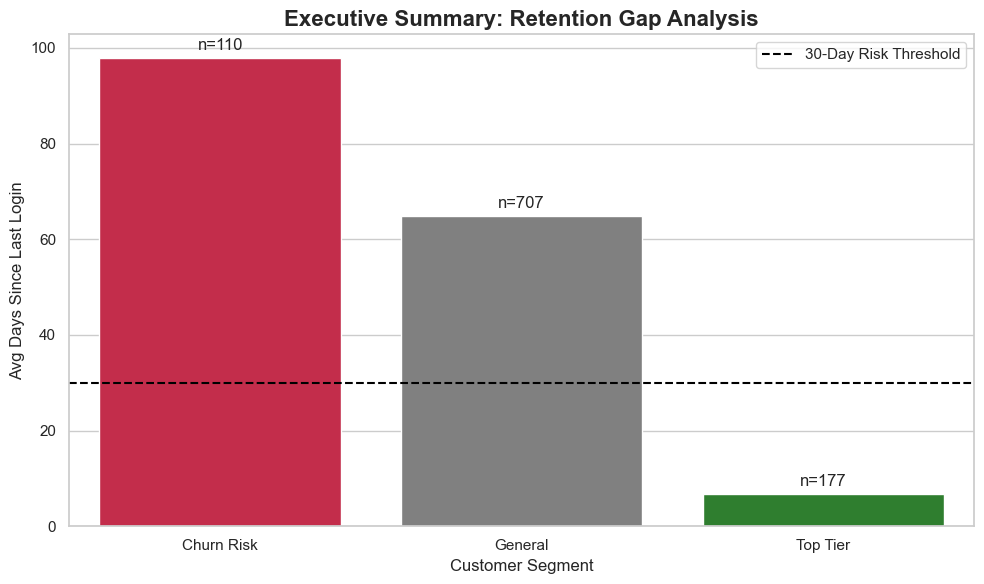

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate segment averages - using 'Frequency' instead of 'CustomerID'
viz_data = rfm_table.groupby('Segment').agg({
    'DaysSinceLastLogin': 'mean',
    'Monetary': 'mean',
    'Frequency': 'count' # Using the renamed column to get the count
}).rename(columns={'Frequency': 'Customer_Count'}).reset_index()

# 2. Set the professional style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# 3. Create the bar plot
# We use the calculated averages for the segments
# Assign x to hue and set legend=False to keep the same look without the warning
plot = sns.barplot(
    data=viz_data, 
    x='Segment', 
    y='DaysSinceLastLogin', 
    hue='Segment', 
    legend=False, 
    palette={'Top Tier': 'forestgreen', 'Churn Risk': 'crimson', 'General': 'gray'}
)


# 4. Executive touches
plt.axhline(30, color='black', linestyle='--', label='30-Day Risk Threshold')
plt.title('Executive Summary: Retention Gap Analysis', fontsize=16, fontweight='bold')
plt.ylabel('Avg Days Since Last Login', fontsize=12)
plt.xlabel('Customer Segment', fontsize=12)
plt.legend()

# Annotate bars with the number of customers in each group
for i, p in enumerate(plot.patches):
    plot.annotate(f"n={int(viz_data.iloc[i]['Customer_Count'])}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [19]:
# Calculate the total monetary value for the 'Churn Risk' segment
churn_risk_revenue = rfm_table[rfm_table['Segment'] == 'Churn Risk']['Monetary'].sum()

# Print the final result formatted as currency
print(f"Total Revenue at Risk: ${churn_risk_revenue:,.2f}")

Total Revenue at Risk: $192,997.68
